In [1]:
%matplotlib inline


In [2]:
import matplotlib.pyplot as plt
import matplotlib
import stistools
import os
from astropy.io import ascii, fits
import glob
from scipy.ndimage import gaussian_filter1d
from astropy.time import Time
import glob
import re
from astropy.table import Table
import astropy.table as at
import astropy
import numpy as np

/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/qinan/anaconda3/envs/stisenv/lib/python3.6/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


In [3]:
matplotlib.rcParams['figure.figsize']      = [15, 5]
matplotlib.rcParams['image.origin']        = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'
matplotlib.rcParams['image.cmap']          = 'inferno'
matplotlib.rcParams['image.aspect']        = 'auto'

In [183]:
#f_dict = {}
spec_log = Table(names = ['phase', 'name', 'file'], dtype = ['i4', 'U8', 'U64'])
for folder in glob.glob('./reduced_spectra/*'):
    objname = folder.split('/')[2]
    f_list = glob.glob(folder+'/*')
#    obj_dict = {}
    for df in f_list:
        t = int(re.findall(r'd\d+', df)[0][1:])
#        obj_dict[t] = df
        spec_log.add_row([t, objname, df])
#    f_dict[objname] = obj_dict
spec_log.sort('phase')

z_dict = {'2010jl':0.0107,
          '2005ip':0.0072,
          '2020aekp':0.046,
          '2020nxt':0.023,
          '1998S':0.003, 
          '2011fe':0.0008,
          '2015G': 0.0045,
          '2021csp':0.083,
          '2017egm':0.030721,
          '2020fqv':0.007522}

type_dict = {'2010jl':'IIn',
          '2005ip':'IIn',
          '2020aekp':'Ia-CSM',
          '2020nxt':'Ibn',
          '1998S':'IIn', 
          '2011fe':'Ia',
          '2015G': 'Ibn',
          '2021csp':'Icn',
          '2017egm':'SLSN-I',
          '2020fqv':'Ia'}

In [197]:
def plot_spec(fname, color, convolve_kernal, z = 0., shift = 0, linestyle = '-', label = None, bin_f = False, bin_size = 1):
    with fits.open(fname) as f:
        if bin_f:
            f_bin = np.zeros(int(len(f[1].data['WAVELENGTH'][0])/bin_size))
            wav_bin = np.zeros(int(len(f[1].data['WAVELENGTH'][0])/bin_size))
            for i in range(int(len(f[1].data['WAVELENGTH'][0])/bin_size)):
                wav_bin[i] = np.average(f[1].data['WAVELENGTH'][0][i*bin_size:i*bin_size+bin_size])
                f_bin[i] = np.sum(f[1].data['FLUX'][0][i*bin_size:i*bin_size+bin_size])
            f_bin = convolve(f_bin, convolve_kernal)
            ind = wav_bin>0
            ind[:50]=False
            ind[int(-250*16/bin_size):]=False
            plt.plot(wav_bin[ind]/(1+z), f_bin[ind]/np.median(f_bin[ind])+shift, color = color, linestyle = linestyle)
        else:
            flux = convolve(f[1].data['FLUX'][0], convolve_kernal)
            ind = f[1].data['WAVELENGTH'][0]>0
            ind[:70]=False
            ind[-70:]=False
            print(fname, len(f[1].data['WAVELENGTH'][0]))
            plt.plot(f[1].data['WAVELENGTH'][0][ind]/(1+z), flux[ind]/np.median(flux[ind])+shift, color = color, 
                     linestyle = linestyle, label = label)

    

./reduced_spectra/2021csp/2021csp_d7NUV_x1d.fits 1024
./reduced_spectra/2021csp/2021csp_d8FUV.fits
./reduced_spectra/2021csp/2021csp_d11NUV.fits 1024
./reduced_spectra/2015G/2015G_d12NUV_x1d.fits 1024
./reduced_spectra/2021csp/2021csp_d13FUV.fits
./reduced_spectra/2020nxt/2020nxt_d18FUV.fits 1024
./reduced_spectra/2020nxt/2020nxt_d18NUV.fits 1024
./reduced_spectra/2020nxt/2020nxt_d27NUV.fits 1024
./reduced_spectra/2017egm/2017egm_d37FUV.fits 1024
./reduced_spectra/2011fe/2011fe_d58FUV_x1d.fits 1024
./reduced_spectra/2011fe/2011fe_d58NUV_x1d.fits 1024
./reduced_spectra/1998S/1998s_d71NUV_x1d.fits 1024
./reduced_spectra/1998S/1998s_d71FUV_x1d.fits 1024
./reduced_spectra/2010jl/2010jl_d95NUV_x1d.fits 1024


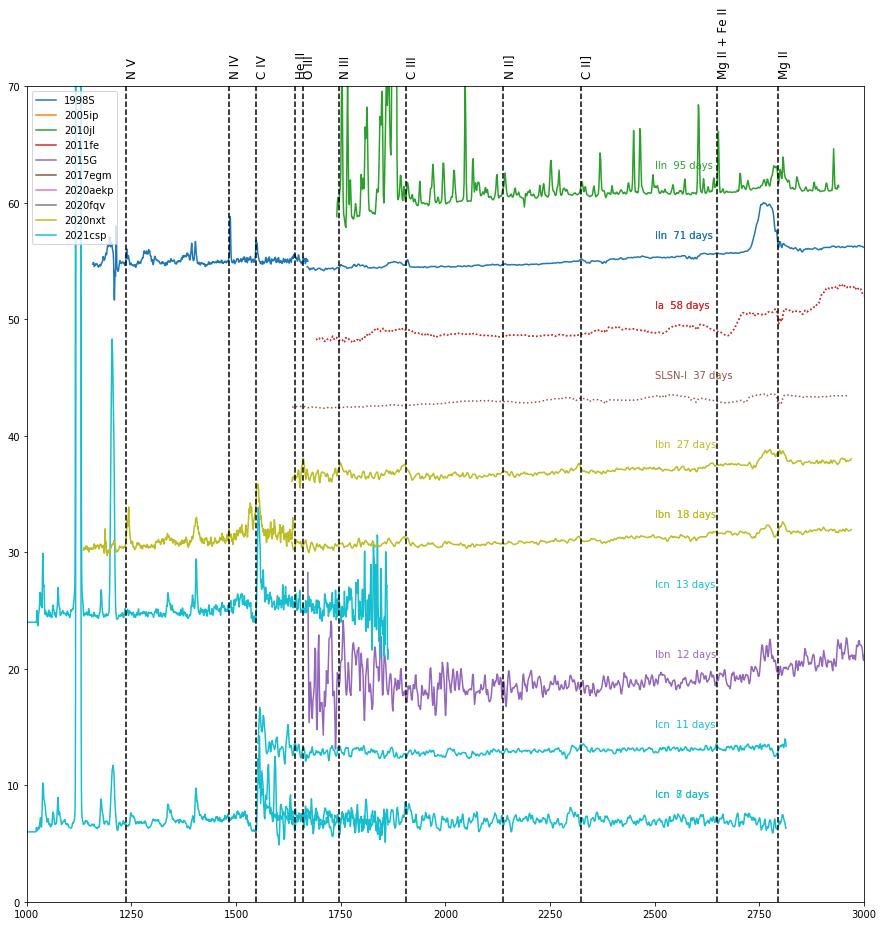

In [200]:
from astropy.convolution import Gaussian1DKernel, convolve

plt.figure(figsize=(15, 15))
g = Gaussian1DKernel(stddev=1)

wav_bin = np.zeros(1024)
f_bin = np.zeros(1024)

j = 0
color_dict = {}
colorcode = 0
#Set up Legend
for name in at.unique(spec_log, keys = 'name')['name']:
    color_dict[name] = 'C'+str(colorcode)
    colorcode+=1
    #plt.scatter([0,1], [0,1], color = color_dict[name], label = name)
    plt.plot([0,1], [0,1], color = color_dict[name], label = name)

shift = 0

for i in range(len(spec_log)):
    spec=  spec_log[i]
    z = z_dict[spec['name']]
    if (type_dict[spec['name']][-1] !='n')& (type_dict[spec['name']][-1]!='M'):
        linestyle = ':'
    else: 
        linestyle = '-'
    if spec['phase']<100 and spec['name']!='2020fqv':
        if i>0 and (((spec['phase']-spec_log[i-1]['phase'])>1) | (spec['name']!=spec_log[i-1]['name'])):
            shift+=6
        if spec['name'] == '2021csp' and 'FUV' in spec['file']:
            print(spec['file'])
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 8)
        else:
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle)
        plt.text(2500, shift+3, type_dict[spec['name']] + '  '+str(spec['phase'])+' days', color = color_dict[spec['name']])    



xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
    plt.text(xcoords[i],shift+11,names[i],rotation=90,fontsize=12)
    #plt.text(xcoords[i],4.6e-17,names[i],rotation=90)

plt.xlim(1000, 3000)
plt.ylim(0, shift+10)
plt.legend()

./reduced_spectra/2020aekp/2020aekp_d203NUV_x1d.fits 1024
./reduced_spectra/1998S/1998s_d236NUV_x1d.fits 1024
./reduced_spectra/1998S/1998s_d236FUV_x1d.fits 1024
./reduced_spectra/2020aekp/2020aekp_d250NUV_x1d.fits 1024
./reduced_spectra/2020aekp/2020aekp_d250FUV_x1d.fits 1024
./reduced_spectra/2011fe/2011fe_d394NUV_x1d.fits 1024
./reduced_spectra/1998S/1998s_d482FUV_x1d.fits 1024
./reduced_spectra/1998S/1998s_d485NUV_x1d.fits 1024
./reduced_spectra/2010jl/2010jl_d557NUV_x1d.fits 1024


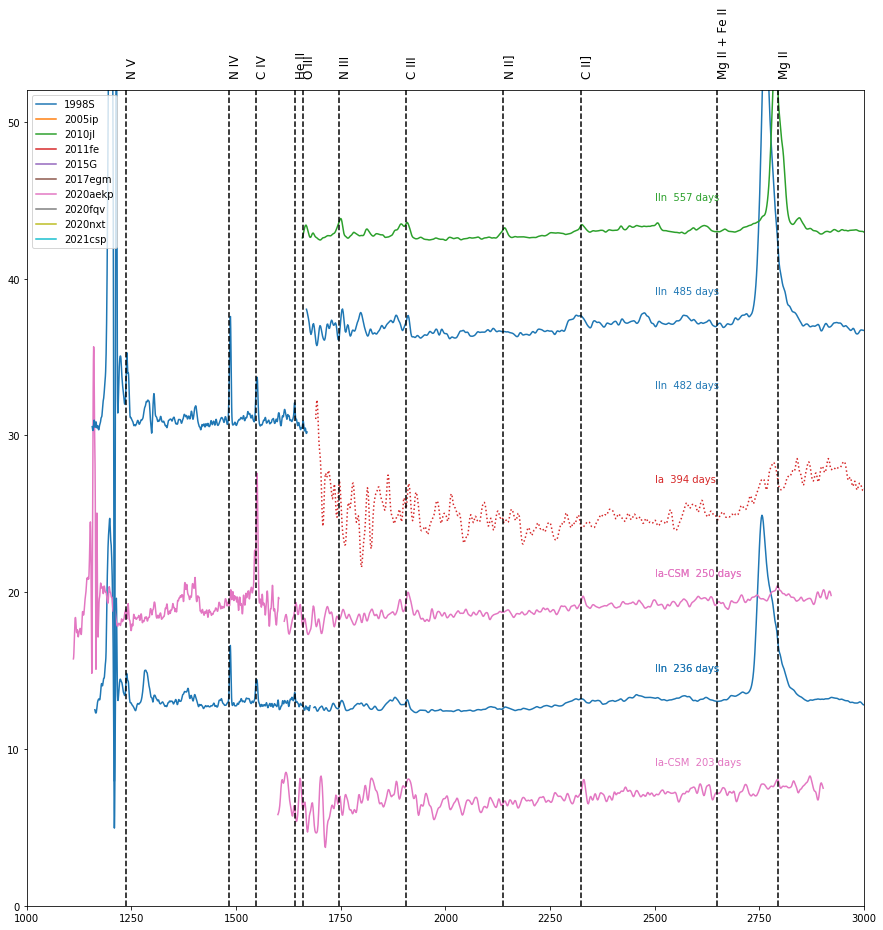

In [199]:
from astropy.convolution import Gaussian1DKernel, convolve

plt.figure(figsize=(15, 15))
g = Gaussian1DKernel(stddev=2)

wav_bin = np.zeros(1024)
f_bin = np.zeros(1024)

j = 0
color_dict = {}
colorcode = 0
#Set up Legend
for name in at.unique(spec_log, keys = 'name')['name']:
    color_dict[name] = 'C'+str(colorcode)
    colorcode+=1
    #plt.scatter([0,1], [0,1], color = color_dict[name], label = name)
    plt.plot([0,1], [0,1], color = color_dict[name], label = name)

shift = 0

for i in range(len(spec_log)):
    spec=  spec_log[i]
    z = z_dict[spec['name']]
    if (type_dict[spec['name']][-1] !='n')& (type_dict[spec['name']][-1]!='M'):
        linestyle = ':'
    else: 
        linestyle = '-'
    if spec['phase']>100 and spec['phase']<1000 and spec['name']!='2020fqv':
        if i>0 and (((spec['phase']-spec_log[i-1]['phase'])>1) | (spec['name']!=spec_log[i-1]['name'])):
            shift+=6
        if spec['name'] == '2021csp' and 'FUV' in spec['file']:
            print(spec['file'])
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 16)
        else:
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle)
        plt.text(2500, shift+3, type_dict[spec['name']] + '  '+str(spec['phase'])+' days', color = color_dict[spec['name']])    


xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
    plt.text(xcoords[i],shift+11,names[i],rotation=90,fontsize=12)
    #plt.text(xcoords[i],4.6e-17,names[i],rotation=90)

plt.xlim(1000, 3000)
plt.ylim(0, shift+10)
plt.legend()

./reduced_spectra/2010jl/2010jl_d1226FUV_x1d.fits 1024
./reduced_spectra/2010jl/2010jl_d1226NUV_x1d.fits 1024
./reduced_spectra/2010jl/2010jl_d1616FUV_x1d.fits 1024
./reduced_spectra/2005ip/2005ip_d3042FUV_x1d.fits 1024
./reduced_spectra/2005ip/2005ip_d3042NUV_x1d.fits 1024
./reduced_spectra/2005ip/2005ip_d4337FUV_x1d.fits 1024
./reduced_spectra/2005ip/2005ip_d4337NUV_x1d.fits 1024


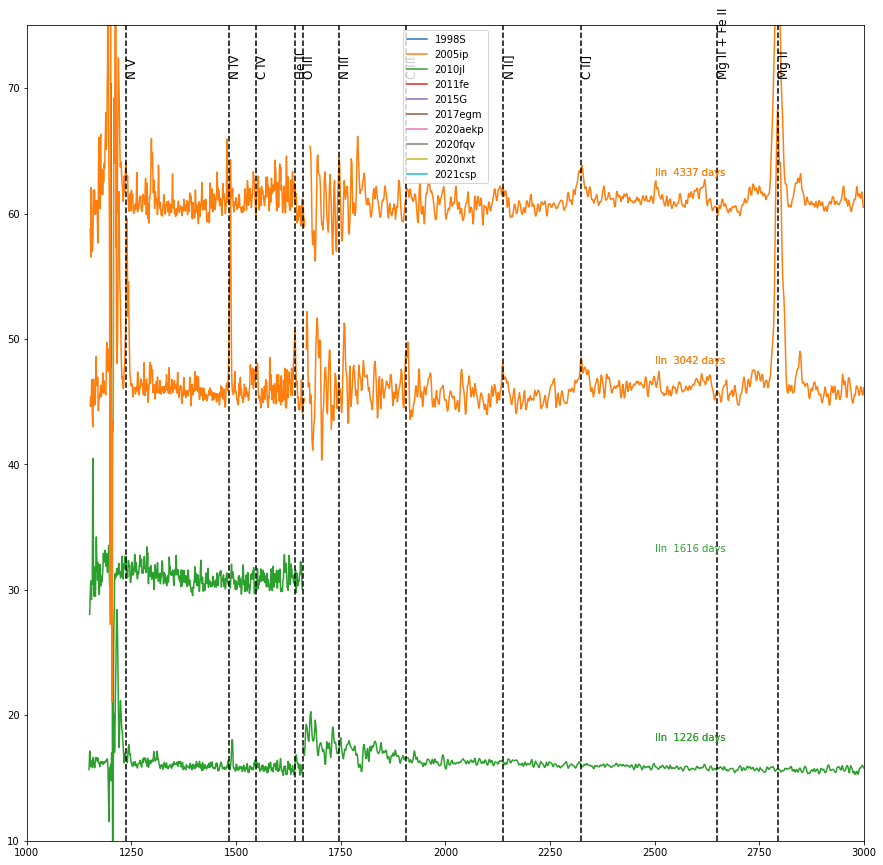

In [193]:
from astropy.convolution import Gaussian1DKernel, convolve

plt.figure(figsize=(15, 15))
g = Gaussian1DKernel(stddev=1)

wav_bin = np.zeros(1024)
f_bin = np.zeros(1024)

j = 0
color_dict = {}
colorcode = 0
#Set up Legend
for name in at.unique(spec_log, keys = 'name')['name']:
    color_dict[name] = 'C'+str(colorcode)
    colorcode+=1
    #plt.scatter([0,1], [0,1], color = color_dict[name], label = name)
    plt.plot([0,1], [0,1], color = color_dict[name], label = name)

shift = 0

for i in range(len(spec_log)):
    spec=  spec_log[i]
    z = z_dict[spec['name']]
    if (type_dict[spec['name']][-1] !='n')& (type_dict[spec['name']][-1]!='M'):
        linestyle = ':'
    else: 
        linestyle = '-'
    if spec['phase']>1000 and spec['name']!='2020fqv' and spec['file']!='./reduced_spectra/2010jl/2010jl_d1616NUV_x1d.fits':
        if i>0 and (((spec['phase']-spec_log[i-1]['phase'])>1) | (spec['name']!=spec_log[i-1]['name'])):
            shift+=15
        if spec['name'] == '2021csp' and 'FUV' in spec['file']:
            print(spec['file'])
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle
                      , bin_f = True, bin_size = 16)
        else:
            plot_spec(spec['file'], color_dict[spec['name']], g, shift = shift, z = z, linestyle = linestyle)
        plt.text(2500, shift+3, type_dict[spec['name']] + '  '+str(spec['phase'])+' days', color = color_dict[spec['name']])    



xcoords=[1238,1484  ,1548  ,1640  ,1660    ,1746   ,1907   ,2139   ,2323   ,2650           , 2795  ]
#xcoords=np.asarray(xcoords)*1.e-4
names=['N V' ,'N IV','C IV','He II','O III','N III','C III','N II]','C II]','Mg II + Fe II','Mg II']
       
for i in range(len(xcoords)):
    plt.axvline(x=xcoords[i],ymax=1,color='black',linestyle='--')
    plt.text(xcoords[i],shift+11,names[i],rotation=90,fontsize=12)
    #plt.text(xcoords[i],4.6e-17,names[i],rotation=90)

plt.xlim(1000, 3000)
plt.ylim(10, shift+15)
plt.legend()

In [ ]:

with fits.open('./reduced_spectra/2021csp/2021csp_d7NUV_x1d.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:50]=False
    ind[-50:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/1.083, flux[ind]/np.median(flux[ind])+0, color = 'C0', label = '2021csp')

with fits.open('./reduced_spectra/2021csp/2021csp_d8FUV.fits') as f:
    for i in range(1024):
        wav_bin[i] = np.average(f[1].data['WAVELENGTH'][0][i*16:i*16+16])
        f_bin[i] = np.sum(f[1].data['FLUX'][0][i*16:i*16+16])
    f_bin = convolve(f_bin, g)
    ind = wav_bin>0
    ind[:50]=False
    ind[-250:]=False
    plt.plot(wav_bin[ind]/1.083, f_bin[ind]/np.median(f_bin[ind])+0, color = 'C0')    

plt.text(2750, 3,'8 days', color = 'C0')    
    
with fits.open('./reduced_spectra/2021csp/2021csp_d13FUV.fits') as f:
    for i in range(1024):
        wav_bin[i] = np.average(f[1].data['WAVELENGTH'][0][i*16:i*16+16])
        f_bin[i] = np.sum(f[1].data['FLUX'][0][i*16:i*16+16])
    f_bin = convolve(f_bin, g)
    ind = wav_bin>0
    ind[:50]=False
    ind[-250:]=False
    plt.plot(wav_bin[ind]/1.083, f_bin[ind]/np.median(f_bin[ind])+8, color = 'C0')
    

with fits.open('./reduced_spectra/2021csp/2021csp_d11NUV.fits') as f:
    print(len(f[1].data['WAVELENGTH'][0]))

    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:50]=False
    ind[-50:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/1.083, flux[ind]/np.median(flux[ind])+8, color = 'C0')

plt.text(2750, 11,'12 days', color = 'C0')    



with fits.open('./reduced_spectra/2015G/2015G_d12NUV_x1d.fits') as f:
    print(len(f[1].data['WAVELENGTH'][0]))

    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:100]=False
    ind[-50:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/1.0045, flux[ind]/np.median(flux[ind])+16, color = 'C1', label = '2015G')

plt.text(2750, 22,'12 days', color = 'C1')    

    
with fits.open('./reduced_spectra/2020nxt/2020nxt_d18NUV.fits') as f:
    print(len(f[1].data['WAVELENGTH'][0]))

    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:30]=False
    ind[-30:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/1.023, flux[ind]/np.median(flux[ind])+24, color = 'C2', label = '2020nxt')

plt.text(2750, 27,'18 days', color = 'C2')    

with fits.open('./reduced_spectra/2020nxt/2020nxt_d18FUV.fits') as f:
    flux = convolve(f[1].data['FLUX'][0], g)
    print(len(f[1].data['WAVELENGTH'][0]))
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:50]=False
    ind[-50:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/1.023, flux[ind]/np.median(flux[ind])+24, color = 'C2')

with fits.open('./reduced_spectra/2020nxt/2020nxt_d27NUV.fits') as f:
    print(len(f[1].data['WAVELENGTH'][0]))

    flux = convolve(f[1].data['FLUX'][0], g)
    ind = f[1].data['WAVELENGTH'][0]>0
    ind[:50]=False
    ind[-50:]=False
    plt.plot(f[1].data['WAVELENGTH'][0][ind]/1.023, flux[ind]/np.median(flux[ind])+30, color = 'C2')
plt.text(2750, 33,'27 days', color = 'C2')    

./2020fqv/wiserep_spectra/2020fqv_2020-04-03_07-40-48_HST_STIS_TNS_0.dat
./2020fqv/wiserep_spectra/2020fqv_2020-04-04_18-57-36_HST_STIS_TNS_0.dat
./2020fqv/wiserep_spectra/2020fqv_2020-04-05_13-26-24_HST_STIS_TNS_0.dat
./2020fqv/wiserep_spectra/2020fqv_2020-04-11_17-16-48_HST_STIS_TNS_0.dat
./2020fqv/wiserep_spectra/2020fqv_2020-04-17_17-16-48_HST_STIS_TNS_0.dat


(-2, 50)

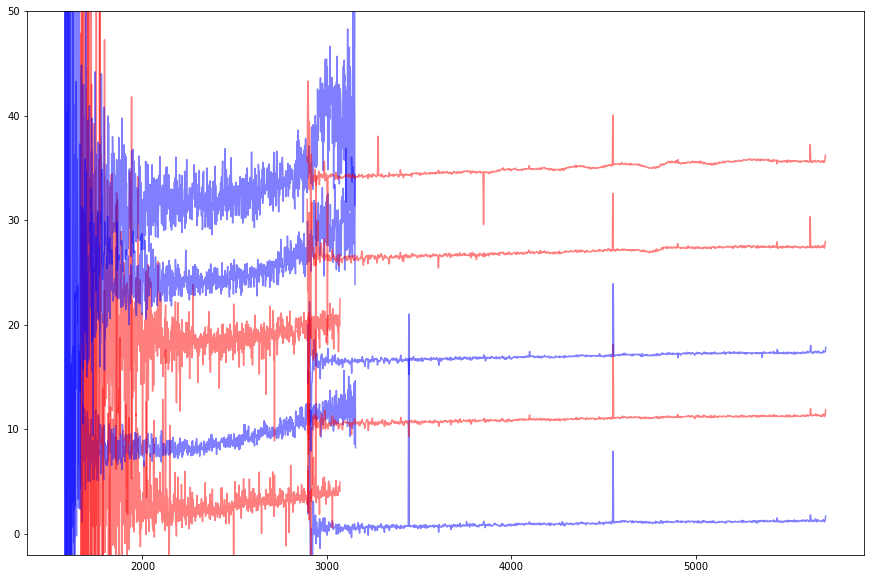

In [113]:
plt.figure(figsize=(15, 10))

import os
j = 0
k = 0
for i in ascii.read('./2020fqv/wiserep_spectra/wiserep_spectra.csv'):
    path = './2020fqv/wiserep_spectra/'+i['Ascii file']
    if os.path.exists(path):
        spec = ascii.read(path)
        print(path)
        plt.plot(spec['col1'], spec['col2']/np.median(spec['col2'])+j, color = 'b', alpha = 0.5)
        spec_n = ascii.read(spec_log[spec_log['name']=='2020fqv'][k]['file'])
        plt.plot(spec_n['col1'], spec_n['col2']/np.median(spec_n['col2'])+j+2, color = 'r', alpha = 0.5)
        k = k+1
        j = j+8
        
plt.ylim(-2, 50)

In [ ]:
Ori's gonna provide 2006jc
1995N: check pipeline product
COS: 2010jl, 2021csp 
    
check the big peak of 2021csp shorter then 1300A NIV
manually check 2010jl late spectra
and reduce 2010jl early spectra
2020aekp July FUV spectra

(-10, 60)

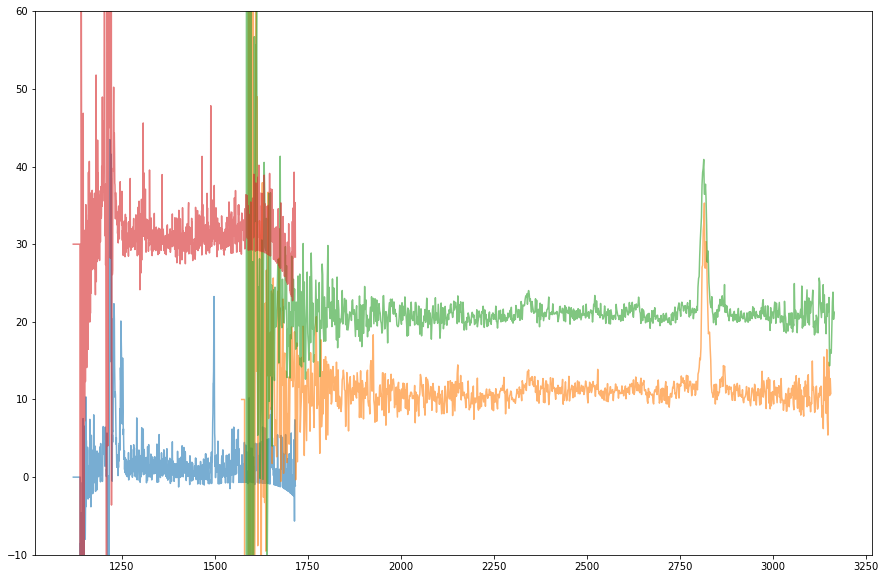

In [17]:
plt.figure(figsize=(15, 10))

j = 0
for spec in spec_log[spec_log['name']=='2005ip']:
    with fits.open(spec['file']) as f:
        plt.plot(f[1].data['WAVELENGTH'][0], f[1].data['FLUX'][0]/np.median(f[1].data['FLUX'][0])+j, 
                     alpha=0.6)
    j +=10
plt.ylim(-10, 60)

In [25]:
spec_log[3]['file'][-4:]

'fits'

In [98]:
f = fits.open('./reduced_spectra/2021csp/2021csp_d8FUV.fits')
f[1]

In [110]:
with fits.open(spec['file']) as f:
    g = ((f[1].data['DQ'][0] & f[1].header['SDQFLAGS']) == 0) & (f[1].data['FLUX']>f[1].data['ERROR'])
    print(f[1].data['WAVELENGTH'][0][g[0]])

[1581.62976385 1587.80479639 1592.43616526 1598.61144971 1601.69914592
 1609.41854392 1612.50636611 1617.13816688 1618.68211847 1624.85801484
 1627.94601702 1632.5780878  1635.66617999 1638.75430819 1644.93067261
 1660.37221385 1669.63757078 1675.81465549 1677.35894918 1680.44756358
 1683.53621401 1685.08055273 1686.62490046 1689.71362293 1691.25799768
 1695.89117597 1702.06887313 1705.15777576 1706.70224059 1708.24671442
 1709.79119727 1723.6919483  1725.23652124 1726.78110319 1739.13808321
 1753.04037516 1757.67463472 1763.85377365 1765.39858092 1773.12275249
 1787.0268293  1790.11672333 1793.20665343 1804.02169283 1805.56673454
 1811.74699154 1814.83717415 1819.47251573 1828.74344242 1831.83382349
 1834.92424064 1842.65044141 1853.46750143 1855.01283182 1856.55817122
 1858.10351965 1861.19424359 1868.92121135 1879.73934529 1882.83032194
 1889.01238356 1896.74016369 1899.83133894 1902.92255031 1907.55943507
 1909.10508138 1913.74207449 1915.28775693 1916.83344839 1918.37914888
 1923.

In [108]:
len(g[0])

1024

In [109]:
len(f[1].data['WAVELENGTH'][0])

ValueError: I/O operation on closed file